# PUBG WINNER PREDICTION

## Dataset Description

In a PUBG game, up to 100 players participate in each match (`matchId`). Players can form teams (`groupId`), which are ranked at the end of the game (`winPlacePerc`) based on how many other teams remain alive when they are eliminated. Players engage in various activities like picking up munitions, reviving teammates, driving vehicles, swimming, running, and shooting. They also face consequences like self-inflicted damage from falls or accidental eliminations.

The dataset provides anonymized post-game statistics for individual players across matches of all types: solos, duos, squads, and custom games. Key considerations:
- Matches may not always have 100 players.
- Teams (`groupId`) can consist of any number of players.

The goal is to build a machine learning model to predict a player's finishing placement (`winPlacePerc`) based on their final stats. The placement is expressed on a scale from 1 (first place) to 0 (last place).

---

### Data Fields
| Feature Name        | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `DBNOs`             | Number of enemy players knocked.                                           |
| `assists`           | Number of enemy players damaged by the player and killed by teammates.     |
| `boosts`            | Number of boost items used.                                                |
| `damageDealt`       | Total damage dealt (self-inflicted damage is subtracted).                  |
| `headshotKills`     | Number of enemy players killed with headshots.                             |
| `heals`             | Number of healing items used.                                              |
| `Id`                | Player’s unique identifier.                                                |
| `killPlace`         | Ranking of the number of enemy players killed.                             |
| `killPoints`        | External ranking based on kills (can be treated as "None" if value is -1). |
| `killStreaks`       | Maximum number of players killed in a short time.                          |
| `kills`             | Number of enemy players killed.                                            |
| `longestKill`       | Longest distance between the player and the enemy killed.                  |
| `matchDuration`     | Duration of the match in seconds.                                          |
| `matchId`           | Unique identifier for the match.                                           |
| `matchType`         | Type of match (e.g., solo, duo, squad, or custom).                         |
| `rankPoints`        | Deprecated Elo-like ranking of players.                                    |
| `revives`           | Number of times the player revived teammates.                              |
| `rideDistance`      | Distance traveled in vehicles (meters).                                    |
| `roadKills`         | Number of kills while in a vehicle.                                        |
| `swimDistance`      | Distance traveled by swimming (meters).                                    |
| `teamKills`         | Number of teammates killed by the player.                                  |
| `vehicleDestroys`   | Number of vehicles destroyed.                                              |
| `walkDistance`      | Distance traveled on foot (meters).                                        |
| `weaponsAcquired`   | Number of weapons picked up.                                               |
| `winPoints`         | External ranking based on wins (can be treated as "None" if value is -1).  |
| `groupId`           | Identifier for the group within a match.                                   |
| `numGroups`         | Total number of groups in the match.                                       |
| `maxPlace`          | Worst placement recorded in the match.                                     |
| `winPlacePerc`      | Target variable: Winning placement percentile (1 = 1st place, 0 = last).   |


# **Data Loading and Initialization**
This section imports necessary libraries and initializes the environment for data analysis and machine learning workflows. It includes tools for data manipulation, visualization, and model training.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import lightgbm as lgb
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
df =pd.read_csv(r"C:\Users\mprat\Downloads\pubg.csv")


# **Data Inspection**
Explore the first and last rows of the dataset, understand the basic statistics, and identify missing values to assess data quality.

In [26]:
df.head()

Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0         0.00      0              0      0         60  ...        0   
1        91.47      0              0      0         57  ...        0   
2        68.00      0              0      0         47  ...        0   
3        32.90      0              0      0         75  ...        0   
4       100.00      0              0      0         45  ...        0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0        0.0000          0          0.00          0               0   
1        0.0045          0         11.04          0               0   
2        0.0000          0          0.00          0               0   
3        0.0000          0          0.00          0               0   
4        0.0000          0          0.00          0               0   

   walkDistance  weaponsAcquired  winPoints  winPlacePerc  
0        244.80                1       1466        0.4444  
1       1434.00                5          0        0.6400  
2        161.80                2          0        0.7755  
3        202.70                3          0        0.1667  
4         49.75                2          0        0.1875  

[5 rows x 29 columns]

In [27]:
df.tail()

Id         groupId         matchId  assists  boosts  \
4446961  afff7f652dbc10  d238e426f50de7  18492834ce5635        0       0   
4446962  f4197cf374e6c0  408cdb5c46b2ac  ee854b837376d9        0       1   
4446963  e1948b1295c88a  e26ac84bdf7cef  6d0cd12784f1ab        0       0   
4446964  cc032cdd73b7ac  c2223f35411394  c9c701d0ad758a        0       4   
4446965  0d8e7ed728b6fd  8c74f72fedf5ff  62a16aabcc095c        0       2   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
4446961         0.00      0              0      0         74  ...        0   
4446962        44.15      0              0      0         69  ...        0   
4446963        59.06      0              0      0         66  ...        0   
4446964       180.40      1              1      2         11  ...        2   
4446965       268.00      0              0      1         18  ...        0   

         rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
4446961        1292.0          0         0.000          0               0   
4446962           0.0          0         0.000          0               0   
4446963           0.0          0         2.184          0               0   
4446964           0.0          0         0.000          0               0   
4446965        1369.0          0         0.000          0               0   

         walkDistance  weaponsAcquired  winPoints  winPlacePerc  
4446961        1019.0                3       1507        0.1786  
4446962          81.7                6          0        0.2935  
4446963         788.7                4          0        0.4815  
4446964        2748.0                8          0        0.8000  
4446965        1244.0                5          0        0.5464  

[5 rows x 29 columns]

In [28]:
df.describe()

assists        boosts   damageDealt         DBNOs  headshotKills  \
count  4.446966e+06  4.446966e+06  4.446966e+06  4.446966e+06   4.446966e+06   
mean   2.338149e-01  1.106908e+00  1.307171e+02  6.578755e-01   2.268196e-01   
std    5.885731e-01  1.715794e+00  1.707806e+02  1.145743e+00   6.021553e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
50%    0.000000e+00  0.000000e+00  8.424000e+01  0.000000e+00   0.000000e+00   
75%    0.000000e+00  2.000000e+00  1.860000e+02  1.000000e+00   0.000000e+00   
max    2.200000e+01  3.300000e+01  6.616000e+03  5.300000e+01   6.400000e+01   

              heals     killPlace    killPoints         kills   killStreaks  \
count  4.446966e+06  4.446966e+06  4.446966e+06  4.446966e+06  4.446966e+06   
mean   1.370147e+00  4.759935e+01  5.050060e+02  9.247833e-01  5.439551e-01   
std    2.679982e+00  2.746294e+01  6.275049e+02  1.558445e+00  7.109721e-01   
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  2.400000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  4.700000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
75%    2.000000e+00  7.100000e+01  1.172000e+03  1.000000e+00  1.000000e+00   
max    8.000000e+01  1.010000e+02  2.170000e+03  7.200000e+01  2.000000e+01   

       ...       revives  rideDistance     roadKills  swimDistance  \
count  ...  4.446966e+06  4.446966e+06  4.446966e+06  4.446966e+06   
mean   ...  1.646590e-01  6.061157e+02  3.496091e-03  4.509322e+00   
std    ...  4.721671e-01  1.498344e+03  7.337297e-02  3.050220e+01   
min    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    ...  0.000000e+00  1.909750e-01  0.000000e+00  0.000000e+00   
max    ...  3.900000e+01  4.071000e+04  1.800000e+01  3.823000e+03   

          teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
count  4.446966e+06     4.446966e+06  4.446966e+06     4.446966e+06   
mean   2.386841e-02     7.918208e-03  1.154218e+03     3.660488e+00   
std    1.673935e-01     9.261157e-02  1.183497e+03     2.456544e+00   
min    0.000000e+00     0.000000e+00  0.000000e+00     0.000000e+00   
25%    0.000000e+00     0.000000e+00  1.551000e+02     2.000000e+00   
50%    0.000000e+00     0.000000e+00  6.856000e+02     3.000000e+00   
75%    0.000000e+00     0.000000e+00  1.976000e+03     5.000000e+00   
max    1.200000e+01     5.000000e+00  2.578000e+04     2.360000e+02   

          winPoints  winPlacePerc  
count  4.446966e+06  4.446965e+06  
mean   6.064601e+02  4.728216e-01  
std    7.397004e+02  3.074050e-01  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  2.000000e-01  
50%    0.000000e+00  4.583000e-01  
75%    1.495000e+03  7.407000e-01  
max    2.013000e+03  1.000000e+00  

[8 rows x 25 columns]

In [5]:
df.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [6]:
df.fillna(0,inplace=True)

In [7]:
df.dtypes

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

In [7]:
profile = ProfileReport(df, title="PUBG Profile Report", explorative=True,minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering

New features are created based on domain knowledge to enhance the predictive power of the dataset. Categories include combat-related, mobility, health, and match dynamics features.


In [8]:
# 1. Combat-Related Features
df['damage_per_kill'] = df['damageDealt'] / (df['kills'] + 1)
df['headshot_ratio'] = df['headshotKills'] / (df['kills'] + 1)
df['survival_kills_ratio'] = df['kills'] / (df['matchDuration'] + 1)
df['DBNOs_per_kill'] = df['DBNOs'] / (df['kills'] + 1)

# 2. Mobility and Distance Features
df['total_distance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']
df['walk_ratio'] = df['walkDistance'] / (df['total_distance'] + 1)

# 3. Health and Recovery
df['heals_and_boosts'] = df['heals'] + df['boosts']

# 4. Team and Match Dynamics
df['revive_ratio'] = df['revives'] / (df['numGroups'] + 1)
df['teamwork_score'] = (df['revives'] + df['assists']) / (df['numGroups'] + 1)

# 5. Engagement Features
df['engagement_ratio'] = (df['kills'] + df['assists'] + df['DBNOs']) / (df['matchDuration'] + 1)

In [9]:
# Match-Level Features
df['total_players_in_match'] = df.groupby('matchId')['Id'].transform('count')
df['total_teams_in_match'] = df.groupby('matchId')['groupId'].transform('nunique')

# Group-Level Features
df['players_in_team'] = df.groupby(['matchId', 'groupId'])['Id'].transform('count')

# Player-Level Relative Features
df['player_kills_rank_in_team'] = df.groupby(['matchId', 'groupId'])['kills'].rank(ascending=False, method='min')
df['player_damage_rank_in_team'] = df.groupby(['matchId', 'groupId'])['damageDealt'].rank(ascending=False, method='min')

In [10]:
# 1. Rank Points Relative to Match Size
df['rank_points_per_player'] = df['rankPoints'] / (df['maxPlace'] + 1)

# 2. Rank Points Per Kill
df['rank_points_per_kill'] = df['rankPoints'] / (df['kills'] + 1)

# Removing Unnecessary Features
Irrelevant or redundant columns like unique identifiers are dropped to reduce noise and improve model performance.


In [11]:
columns_to_drop = [
    'Id', 'groupId', 'matchId','matchType']

# Drop the columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)

# Take sample for debugging and exploration
sample = 2000000
df_sample = df.sample(sample)

In [12]:
# Split sample into training data and target variable
y = df['winPlacePerc']
df = df.drop(columns = ['winPlacePerc'])

# Correlation Analysis and Feature Reduction
Highly correlated features are identified and removed to avoid multicollinearity, ensuring the model remains interpretable and efficient.

In [15]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set a threshold for high correlation
threshold = 0.8

# Create a set to hold features to drop
to_drop = set()

# Iterate through the correlation matrix
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:  # Check high correlation
            colname = correlation_matrix.columns[j]  # Column to drop
            to_drop.add(colname)

# Drop the highly correlated features
df_dropped = df.drop(columns=to_drop)

# Print dropped features
print("Dropped features:", to_drop)

Dropped features: {'revive_ratio', 'rank_points_per_kill', 'total_distance', 'rank_points_per_player', 'killStreaks', 'kills', 'heals_and_boosts', 'headshot_ratio', 'numGroups', 'rankPoints', 'survival_kills_ratio', 'winPoints', 'total_teams_in_match', 'engagement_ratio'}


In [16]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(df_dropped, y, test_size=0.2, random_state=42)

# Check dimensions of the splits
print(f'Train shape: {X_train.shape}, Target shape: {y_train.shape}')
print(f'Validation shape: {X_test.shape}, Validation target shape: {y_test.shape}')

Train shape: (3557572, 27), Target shape: (3557572,)
Validation shape: (889394, 27), Validation target shape: (889394,)


# Baseline Model: Linear Regression
A simple linear regression model is trained as a baseline to compare with more advanced models. The R² score is used to evaluate its performance.

In [21]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg_pred = lin_reg.predict(X_test)
print("Linear Regression R² Score:", r2_score(y_test, lin_reg_pred))
rmse = mean_squared_error(y_test, lin_reg_pred)
print("Linear Regression RMSE:", rmse)

Linear Regression R² Score: 0.8316351190944142
Linear Regression RMSE: 0.015904681752574278


# Model Training: LightGBM Default Parameters
LightGBM, a gradient boosting framework, is trained using default parameters to establish its effectiveness with minimal tuning.

In [41]:
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train the model (LightGBM will use default parameters)
model = lgb.train({}, train_data, valid_sets=[train_data, val_data])
# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Calculate RMSE for validation set
rmse = mean_squared_error(y_test, y_pred)
print(f'Validation RMSE: {rmse:.4f}')

# Calculate R² score for validation set
r2 = r2_score(y_test, y_pred)
print(f'Validation R² score: {r2:.4f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.292503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3098
[LightGBM] [Info] Number of data points in the train set: 3557572, number of used features: 27
[LightGBM] [Info] Start training from score 0.472873
Validation RMSE: 0.0063
Validation R² score: 0.9335


In [21]:
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Define the objective function for Bayesian optimization
def lgb_evaluate(num_leaves, max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'metric': 'rmse'
    }

    model = lgb.LGBMRegressor(**params,verbosity=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)
    return -rmse  # To minimize

# Define the search space
param_bounds = {
    'num_leaves': (20, 150),
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 1000),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# Run Bayesian optimization
optimizer = BayesianOptimization(f=lgb_evaluate, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Print the best parameters found
print("Best Parameters:", optimizer.max['params'])

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3105
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 27
[LightGBM] [Info] Start training from score 0.472302
| 1         | -0.005671 | 0.6873    | 0.2857    | 9.588     | 618.7     | 40.28     | 0.578     |
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3105
[LightGBM] [Info] Number of data points

# Optimized LightGBM Model
A fine-tuned LightGBM model is trained with hyperparameters optimized for performance. The model is evaluated on the validation set using RMSE and R² scores.

In [42]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

model = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    colsample_bytree=0.8277,
    learning_rate=0.0438,
    max_depth=9,
    n_estimators=856,
    num_leaves=150,
    subsample=0.9245,
    metric='rmse',
    verbosity=-1 
)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE for the validation set
rmse = mean_squared_error(y_test, y_pred)
print(f'Validation RMSE: {rmse:.4f}')

# Calculate R² score for the validation set
r2 = r2_score(y_test, y_pred)
print(f'Validation R² score: {r2:.4f}')

Validation RMSE: 0.0054
Validation R² score: 0.9432


# Feature Importance Visualization
Visualizes the top contributing features to the LightGBM model, helping understand what drives predictions.

<Figure size 1200x800 with 0 Axes>

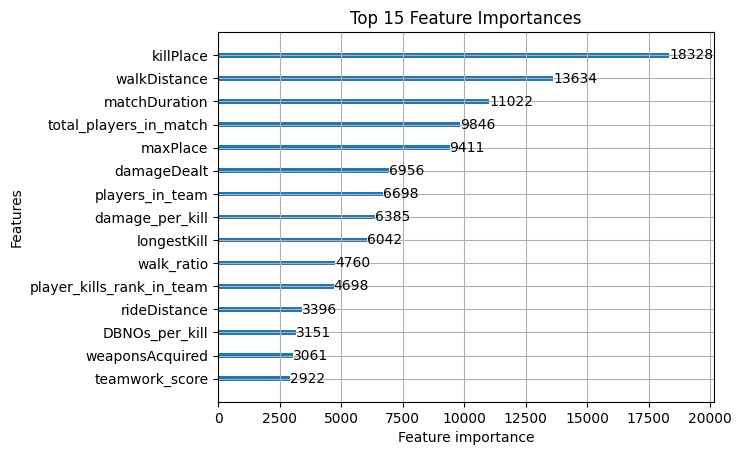

In [47]:
# Plot feature importances
%matplotlib inline
plt.figure(figsize=(12, 8))
lgb.plot_importance(model, importance_type='split', max_num_features=15, title='Top 15 Feature Importances')
plt.show()

# Model Evaluation: Visualizing Performance
Generates diagnostic plots to evaluate the model's performance:
1. Actual vs. Predicted values.
2. Residuals vs. Predicted values.
3. Histogram of residuals.
4. QQ Plot for residuals

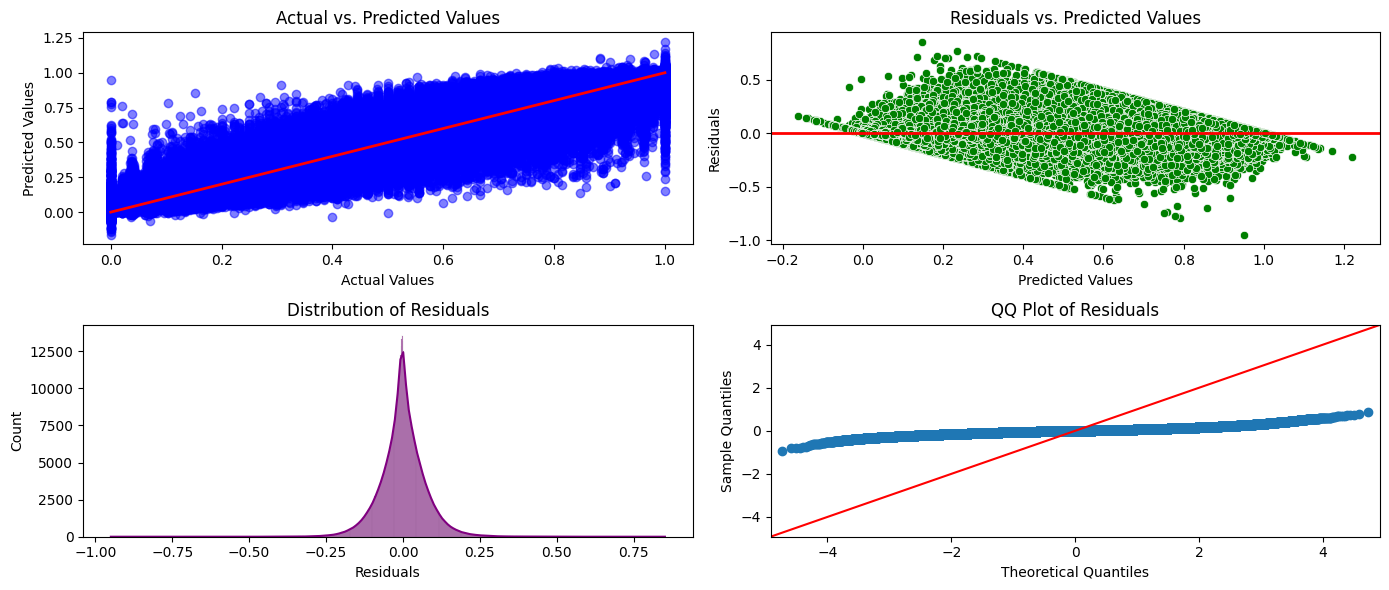

In [48]:
# Predicted vs. Actual Values Plot
plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Residuals vs. Predicted Values Plot
residuals = y_test - y_pred
plt.subplot(2, 2, 2)
sns.scatterplot(x=y_pred, y=residuals, color='green')
plt.axhline(0, color='red', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

# Histogram of Residuals
plt.subplot(2, 2, 3)
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')

# QQ Plot of Residuals
plt.subplot(2, 2, 4)
sm.qqplot(residuals, line='45', ax=plt.gca())
plt.title('QQ Plot of Residuals')

plt.tight_layout()
plt.show()

# Model Evaluation Results

### Evaluation Metrics
- **Root Mean Square Error (RMSE)**: Measures the average difference between predicted and actual values. Lower RMSE indicates better model performance.
- **R² Score**: Indicates the proportion of variance in the target variable explained by the model. Values closer to 1 represent better performance.

---

### RMSE Comparison

| Model                         | RMSE (Baseline) | RMSE (Optimized) |
|-------------------------------|-----------------|------------------|
| **Linear Regression**         | 0.0159 | N/A              |
| **LightGBM**                  | 0.0082          | **0.0054**       |

---

### R² Score Comparison

| Model                         | R² Score (Baseline) | R² Score (Optimized) |
|-------------------------------|---------------------|-----------------------|
| **Linear Regression**         | 0.8316 | N/A                  |
| **LightGBM**                  | 0.8547             | **0.9432**           |

---

### Feature Importance (LightGBM)
- Key features contributing to the prediction:
  - **Kills**: Strongest predictor of performance, indicating combat effectiveness.
  - **DamageDealt**: Highlights overall combat contribution.
  - **Boosts**: Tracks in-game performance enhancers used by players.

---

### Visualization Insights
- **Actual vs. Predicted Values**:
  - Shows strong alignment, indicating high prediction accuracy.
- **Residual Analysis**:
  - Residuals are randomly distributed around zero, confirming minimal bias in predictions.
- **Feature Importance Plot**:
  - Visualizes the relative contribution of each feature to the model's predictions.

---

### Observations
1. **Baseline Model Performance**:
   - RMSE: **0.0159**
   - R² Score: **0.8316**
   - RMSE was high, and R² was low, indicating poor performance.

2. **Optimized Model Performance**:
   - LightGBM, after hyperparameter optimization, achieved:
     - RMSE: **0.0054**
     - R² Score: **0.9432**
   - Efficiently captured complex relationships and handled the large dataset effectively.

---

### Conclusion
- The **LightGBM** model outperformed the baseline Linear Regression model in all metrics.
- With optimized hyperparameters, LightGBM provided robust and accurate predictions, making it the preferred choice for PUBG Winner Prediction.

### Challenges Faced in the PUBG Winner Prediction Project

#### 1. Data Handling and Cleaning
- **Large Dataset Size**:
  - The dataset was extensive, leading to high memory usage during operations such as data loading, preprocessing, and feature engineering.
  - Memory errors were encountered during model training with Linear Regression due to its high resource demands.

- **Missing Values**:
  - Identifying and handling missing values was critical to maintain data integrity. Missing values were filled appropriately to avoid biases.

- **Imbalanced Features**:
  - Some features exhibited skewed distributions or low variance, impacting their usefulness in predictive modeling.

#### 2. Feature Engineering
- **Complexity of Game Dynamics**:
  - Translating PUBG's intricate gameplay mechanics into meaningful features required domain expertise.
  - Examples of engineered features: `damage_per_kill`, `headshot_ratio`, and `total_players_in_match`.
    

- **High Dimensionality**:
  - The dataset contained numerous features, many of which were highly correlated. Reducing dimensionality without losing critical information posed a challenge.

#### 3. Correlation and Multicollinearity
- **Redundant Features**:
  - Highly correlated features were identified through correlation analysis. Removing these features to avoid multicollinearity while preserving predictive power required careful evaluation.

#### 4. Model Training
- **Memory Errors**:
  - Training a baseline Linear Regression model caused memory allocation issues due to the dataset's size and complexity.
  - Resource-efficient models like LightGBM were implemented to overcome these constraints.

- **Model Optimization**:
  - Tuning hyperparameters for LightGBM using Bayesian optimization required significant computational resources and careful parameter exploration.